# Deep Galerkin Method Implementation in Black Scholes Equation - Predicting the Stock Price

In [1]:
from matplotlib import pyplot as plt

from black_scholes_trainer import BS_Solver_Generalized
from black_scholes_pde_residuals import *
import numpy as np
from utility_functions import get_device
from visualize_bs import plot_2d_solution_surface

## Default Hyper Parameters

In [2]:
EPOCHS = 15
LR = 1e-4
PDE_POINTS = 10000
BC_POINTS = 2000
IC_POINTS = 2000
LAMBDA_BC = 100
LAMBDA_IC = 1000
device = get_device()

# 1D Black Scholes Equation Example

In [3]:
s_min, s_max = 0.1, 200.0
t_min, t_max = 0, T_exp_BS # Time Range (time elapsed)
domain_bound = [[s_min, s_max],[t_max, t_min]]
layer_sizes = [64,64,64,64,64,1]

# Creating a Model

In [4]:
solver = BS_Solver_Generalized(spatial_dimension = 1,  layer_sizes = layer_sizes)

pde_params_bs = {'r_bs': R_BS, 'sigma_bs': Sigma_BS, 'K_bs': K_BS, 'T_exp_bs': T_exp_BS}

Using device: mps


# Model Training

In [5]:
solver.train(pde_residual_func= black_scholes_pde_residual_1d, pde_parameters= pde_params_bs,
              domain_bound = domain_bound,
              boundary_condition_func= black_scholes_boundary_condition_1d,
              num_pde_points = PDE_POINTS,num_bc_points = BC_POINTS,
              epochs= EPOCHS, learning_rate=  LR,lambda_bc = LAMBDA_BC,lambda_ic=LAMBDA_IC,
              initial_condition_func = black_scholes_initial_condition_1d, num_ic_points = IC_POINTS)

Debug: lambda_bc = 100
Debug: lambda_ic = 1000

 --- Training Loop for DGM for 1 spatial dimensional pde on mps


Training Black Scholes Example::  27%|██▋       | 4/15 [00:00<00:01,  7.05it/s]

Epoch 1/15: Total Loss=1.6902e+06, PDE Loss=1.6822e-03, BC Loss=5.4568e-01, IC Loss=1.6901e+03


Training Black Scholes Example:: 100%|██████████| 15/15 [00:01<00:00, 13.32it/s]

Training complete.


# Plotting the Graphs

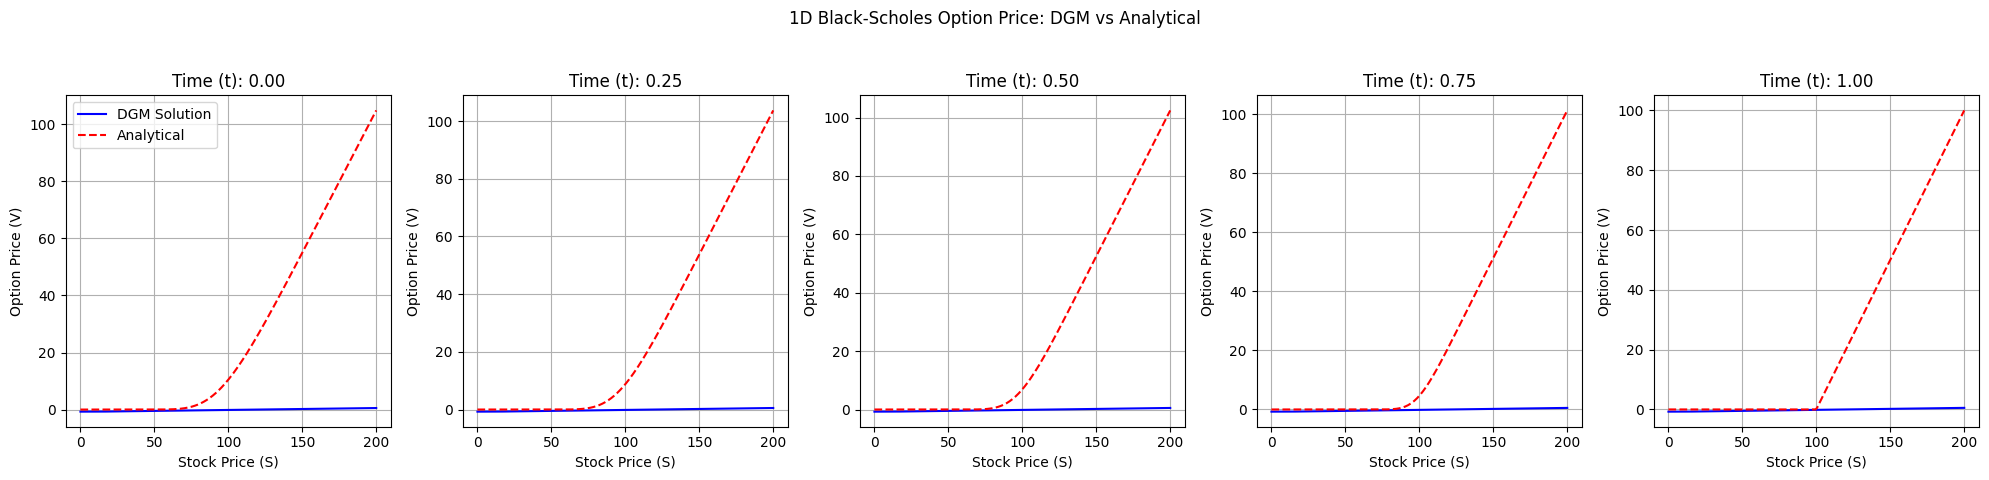

In [6]:
plot_times = [0.0, T_exp_BS * 0.25, T_exp_BS * 0.5, T_exp_BS * 0.75, T_exp_BS]
s_test = torch.linspace(s_min, s_max, 200).reshape(-1, 1).to(device)

fig, axes = plt.subplots(1, len(plot_times), figsize=(20, 5))
fig.suptitle("1D Black-Scholes Option Price: DGM vs Analytical")
for i, t_val in enumerate(plot_times):
    t_test = torch.full_like(s_test, t_val).to(device)
    s_t_test = torch.cat([s_test, t_test], dim=1)

    dgm_solution = solver.predict(s_t_test).cpu().detach().numpy()
    analytical_solution = black_scholes_analytical_1d(s_test, t_test).cpu().detach().numpy()

    ax = axes[i]
    ax.plot(s_test.cpu().numpy(), dgm_solution, label='DGM Solution', color='blue')
    ax.plot(s_test.cpu().numpy(), analytical_solution, label='Analytical', linestyle='--', color='red')
    ax.set_title(f"Time (t): {t_val:.2f}")
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel("Option Price (V)")
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2D Black Scholes Equation Example

In [7]:
s1_min, s1_max = 0.1, 200.0
s2_min, s2_max = 0.1, 200.0
t_min,t_max = 0, T_exp_BS
domain_bound = [[s1_min, s1_max],[s2_min, s2_max],[t_min, t_max]]
layer_sizes = [128, 128, 128, 1]

# Creating a Model

In [8]:
solver = BS_Solver_Generalized(spatial_dimension = 2,  layer_sizes = layer_sizes)

pde_params_bs = {'r_bs': R_BS, 'sigma1_bs': Sigma_BS,'sigma2_bs':Sigma_BS,'rho_bs':0.5, 'K_bs': K_BS, 'T_exp_bs': T_exp_BS}


Using device: mps


# Training the Model

In [9]:
solver.train(pde_residual_func= black_scholes_pde_residual_2d, pde_parameters= pde_params_bs,
              domain_bound = domain_bound,
              boundary_condition_func= lambda x_coords,t_coords:black_scholes_boundary_condition_2d(x_coords,t_coords),
              num_pde_points = PDE_POINTS * 4,num_bc_points = BC_POINTS * 4,
              epochs= EPOCHS * 2, learning_rate=  LR * 0.5,lambda_bc = LAMBDA_BC * 10, lambda_ic = LAMBDA_IC * 20,
              initial_condition_func =lambda x_coords: black_scholes_initial_condition_2d(x_coords), num_ic_points = IC_POINTS)

Debug: lambda_bc = 1000
Debug: lambda_ic = 20000

 --- Training Loop for DGM for 2 spatial dimensional pde on mps


Training Black Scholes Example::   3%|▎         | 1/30 [00:00<00:13,  2.09it/s]

Epoch 1/30: Total Loss=3.5678e+08, PDE Loss=3.5145e-03, BC Loss=1.3358e+04, IC Loss=1.7171e+04


Training Black Scholes Example:: 100%|██████████| 30/30 [00:03<00:00,  7.73it/s]

Training complete.


# Plotting the Graphs

In [10]:
num_plot_points = 30
plot_t = domain_bound[2][1]

s1_grid, s2_grid = np.meshgrid(np.linspace(s1_min, s1_max, num_plot_points),
                               np.linspace(s2_min, s2_max, num_plot_points))
s1_test_flat = torch.tensor(s1_grid.ravel(), dtype=torch.float32).reshape(-1, 1).to(device)
s2_test_flat = torch.tensor(s2_grid.ravel(), dtype=torch.float32).reshape(-1, 1).to(device)
t_test_flat = torch.full_like(s1_test_flat, plot_t).to(device)

X_test_2d_plot = torch.cat([s1_test_flat, s2_test_flat, t_test_flat], dim=1)

dgm_solution_2d = solver.predict(X_test_2d_plot)
analytical_solution_2d = black_scholes_analytical_2d(s1_test_flat, s2_test_flat, t_test_flat)  # Placeholder

plot_2d_solution_surface(torch.cat([s1_test_flat, s2_test_flat], dim=1), dgm_solution_2d, analytical_solution_2d,
                         f"2D Black-Scholes (t={plot_t:.2f}) - DGM vs Placeholder Analytical", "S1", "S2")


TypeError: plot_2d_solution_surface() takes from 2 to 5 positional arguments but 6 were given